## Data Mining Project 
##### Noelle Reid
### Dataset Selection / Problem Introduction 
The dataset used for this project is the [Diabetes Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data) obtained from Kaggle. This dataset contains 253,680 survey responses to the CDC's BRFSS2015. The target variable is Diabetes_012 which has three classes; 0 indicates no diabetes / present only during pregnancy, 1 represents prediabetes, and 2 indicates diabetes. There are 21 feature variables, including but not limited to high blood pressure, high cholesterol, BMI, smoker, etc. The goal of this project is to utilize K-means clustering to identify patterns in the data then utilize cross validation to find the best model (logistic regression vs decision tree) to classify the data based on diabetic status. There is a specific focus on high blood pressure's relationship to diabetes. 
### Data Preprocessing & EDA

In [1]:
# load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# load dataset 
df = pd.read_csv('/Users/noellereid/Desktop/SPRING 2024/DS 380/diabetes.csv')
# inspect dataset 
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [2]:
df.info()
# no null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

#### Cleaning Procedures:
1. rename some of the variables for readability

In [3]:
# rename target variable
df.rename(columns={'Diabetes_012': 'diabetes'}, inplace=True)

# check that target variable has only three outcomes
print(df['diabetes'].unique())

[0. 2. 1.]


In [4]:
# rename columns for syntax purposes
# mentHealth = how many days in past month mental health was not good
# physHealth = how many days in past month physical health was not good
df.rename(columns={'MentHlth' : 'mentHealth'}, inplace=True)
df.rename(columns={'PhysHlth' : 'physHealth'}, inplace=True)

2. create a new target variable with only two outcomes to compare diabetics to not diabetics
- analysis only concerns diabetic or not, so prediabetic category is unnecessary 

In [5]:
# add a new col for target variable with only two outcomes; 0 for no diabetes/prediabetes, 1 for diabetes
df['diabetes1'] = df['diabetes'].apply(lambda x: 1 if x == 2.0 else 0)

3. make sure all age and income groups are accounted for -- ensures we have a complete perspective of the data

In [6]:
# make sure all age groups are accounted for 
print(sorted(df['Age'].unique()))
# make sure all income groups are accounted for 
print(sorted(df['Income'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


4. recategorize cols so data are grouped correctly 

In [7]:
# reorder values of general health so that 1 is poor and 5 is excellent
dict = {1.0 : 5, 2.0:4, 3.0:3, 4.0:2, 5.0:1}
df['genHealth'] = df['GenHlth'].map(dict)

In [8]:
# reorganize education col so that 1,2,3 (did not graduate high school according to code book) are one category 
# 1: did not graduate high school, 2: high school grad, 3: attended college/tech school, 4: college/tech school grad
dict1 = {1.0 :1, 2.0:1, 3.0:1, 4.0:2, 5.0:3, 6.0:4}
df['education'] = df['Education'].map(dict1)

#### Visualize:
1. statistical summary
- 43% of dataset has high blood pressure, 42% high cholesterol. consider multicolinearity
- 76% have exercised in past month, 44% smokers
- 44% are male: decent split between genders. data shouldn't be heavily weighted towards one gender. 

In [9]:
# statistical summary of numerical columns
df.describe()

,diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,mentHealth,physHealth,DiffWalk,Sex,Age,Education,Income,diabetes1,genHealth,education
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333,3.488608,3.067743
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294,1.068477,0.939035
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000,3.000000,2.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000,4.000000,3.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000,4.000000,4.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000,5.000000,4.000000


2. correlation matrix
- want to see if there is redundant information or if one variable highly impacts another
- note: most correlations are moderate to weak
- moderate positive correlation between high BP and high cholesterol 
- moderate negative correlation between general Health and high BP 
- correlation suggests as age increases so does high BP 

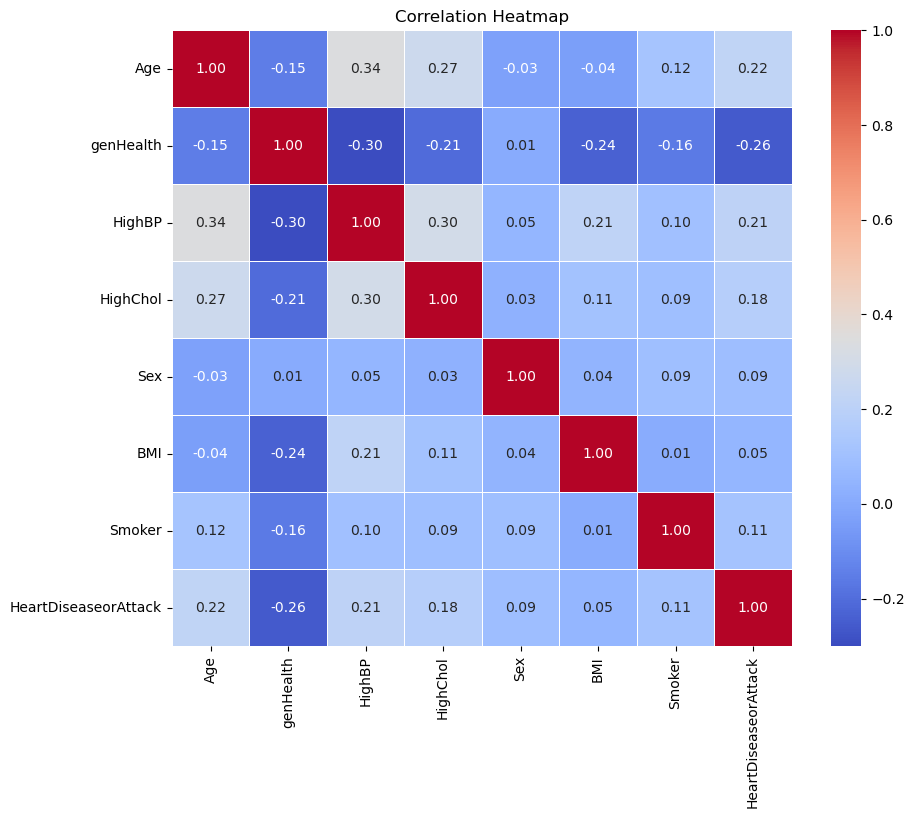

In [10]:
# correlation matrix
# pull necessary cols from dataframe
cols = ['Age','genHealth','HighBP','HighChol','Sex','BMI','Smoker','HeartDiseaseorAttack']
sub_df = df[cols].copy()

# create correlation matrix
corr_mat = sub_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

3. variable averages by blood pressure group
- done to see differences in variables based on blood pressure
- presense of diabetes is significantly higher for those w highBP
- same with highChol 
- more heart attacks for those w highBP
- low BP exercised more frequently on average 

In [11]:
# group by blood pressure
df1 = df.groupby('HighBP')
# calculate averages for groups
av_bp_group = df1.mean(numeric_only = True)
# return averages based on blood pressure groups
print("averages for high bp and no high bp :")
print(av_bp_group)

averages for high bp and no high bp :
        diabetes  HighChol  CholCheck        BMI    Smoker    Stroke  \
HighBP                                                                 
0.0     0.132564  0.296380   0.946483  27.157949  0.401406  0.018412   
1.0     0.515681  0.594143   0.984214  30.012056  0.498755  0.070064   

        HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  \
HighBP                                                          ...   
0.0                 0.041180      0.803143  0.651186  0.832193  ...   
1.0                 0.164736      0.694521  0.611721  0.783771  ...   

        mentHealth  physHealth  DiffWalk       Sex       Age  Education  \
HighBP                                                                    
0.0       2.822024    3.023873  0.095719  0.417878  7.120234   5.171217   
1.0       3.667589    5.863511  0.264727  0.470242  9.245835   4.889671   

          Income  diabetes1  genHealth  education  
HighBP                             

4. frequency of diabetes by gender
- does not vary much (see stacked bar chart)

In [12]:
# proportion of diabetes by sex
num_females_with_diabetes = df[(df['Sex'] == 0) & (df['diabetes1'] == 1)].shape[0]
num_females_without_diabetes = df[(df['Sex'] == 0) & (df['diabetes1'] == 0)].shape[0]
num_males_with_diabetes = df[(df['Sex'] == 1) & (df['diabetes1'] == 1)].shape[0]
num_males_without_diabetes = df[(df['Sex'] == 1) & (df['diabetes1'] == 0)].shape[0]
num_females = df[df['Sex'] == 0].shape[0]
num_males = df[df['Sex'] == 1].shape[0]
print("proportion of females with diabetes:", num_females_with_diabetes / num_females)
print("proportion of males with diabetes:",num_males_with_diabetes / num_males)

proportion of females with diabetes: 0.12967867355994758
proportion of males with diabetes: 0.1516033158469554


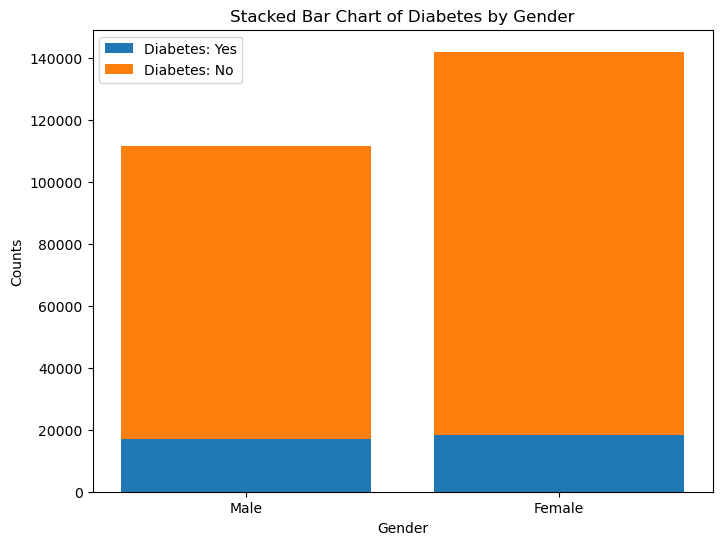

In [13]:
# Visualize frequency of diabetes by gender 
# create data frames necessary for plotting
gender = ['Male', 'Female']
diabetes_yes = [num_males_with_diabetes, num_females_with_diabetes]  # Counts of individuals with diabetes
diabetes_no = [num_males_without_diabetes, num_females_without_diabetes ]   # Counts of individuals without diabetes

# plot a stacked bar chart 
plt.figure(figsize=(8, 6))
plt.bar(gender, diabetes_yes, label='Diabetes: Yes')
plt.bar(gender, diabetes_no, bottom=diabetes_yes, label='Diabetes: No')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Stacked Bar Chart of Diabetes by Gender')
plt.legend()
plt.show()

5. frequency of diabetes by blood pressure
- there is a higher count of diabetes for those w high bp comapred to low (see stacked bar chart)

In [14]:
# proportion of diabetes by bp : 
low_with_diabetes = df[(df['HighBP'] == 0) & (df['diabetes1'] == 1)].shape[0]
low_without_diabetes = df[(df['HighBP'] == 0) & (df['diabetes1'] == 0)].shape[0]
high_with_diabetes = df[(df['HighBP'] == 1) & (df['diabetes1'] == 1)].shape[0]
high_without_diabetes = df[(df['HighBP'] == 1) & (df['diabetes1'] == 0)].shape[0]
num_low = df[df['HighBP'] == 0].shape[0]
num_high = df[df['HighBP'] == 1].shape[0]
print("proportion of high bp with diabetes:", high_with_diabetes / num_high)
print("proportion of low bp with diabetes:",low_with_diabetes / num_low)

proportion of high bp with diabetes: 0.24445690027474296
proportion of low bp with diabetes: 0.06035167171783419


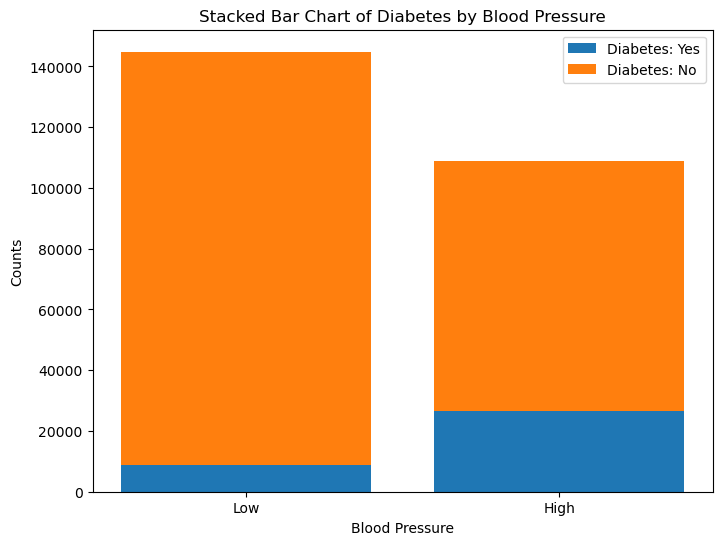

In [15]:
# Visualize frequency of diabetes by blood pressure 
# create data frames necessary for plotting
bp = ['Low', 'High']
diabetes_yes = [low_with_diabetes, high_with_diabetes]  # Counts of individuals with diabetes
diabetes_no = [low_without_diabetes, high_without_diabetes ]   # Counts of individuals without diabetes

# plot a stacked bar chart 
plt.figure(figsize=(8, 6))
plt.bar(bp, diabetes_yes, label='Diabetes: Yes')
plt.bar(bp, diabetes_no, bottom=diabetes_yes, label='Diabetes: No')
plt.xlabel('Blood Pressure')
plt.ylabel('Counts')
plt.title('Stacked Bar Chart of Diabetes by Blood Pressure')
plt.legend()
plt.show()

### EDA Results

After investigating the dataset to understand its characteristics and uncover patterns within the data, we found that about only 14% of the respondents have diabetes, while the rest are either prediabetic or not diabetic. A brief statistical summary reveals that 43% of respondents have high blood pressure, and 42% have high cholesterol. Since these proportions were so similar, we considered if multicolinearity was present. The correlation matrix shows that most of the correlations between relevant variables were moderate to weak. Since there is only a moderate positive correlation between high BP and high cholesterol, we can confirm there is not a risk of having redundant information in the model.

A similar relationship was found between blood pressure and age, insinuating that as age increases, so does the risk of having high blood pressure. Also, the negative correlation betweeen general health and high blood pressure indicates that as general health increases, the risk of having high blood pressure decreases. We also found that those with high blood pressure had more heart attacks / diseases, and exercised less on average compared to respondents with low blood pressure. 

Within the data, those with high blood pressure had a much higher prevalence of diabetes than those without high blood pressure. The same was found for those with high cholesterol levels. There was not a significant difference in diabetic status based on sex as 13% of the women in the study were diabetics, as were 15% of the men. However, 24% of those with high blood pressure were diabetics, compared to only 6% of those without high blood pressure.

### Feature Engineering and Selection 
- eliminated features not being used. considered using principal component analysis but it's not overly applicable to this dataset

In [16]:
# eliminate unnecessary features 
drop_cols = ['Education','GenHlth']
df.drop(columns=drop_cols, inplace=True)

### Machine Learning Techniques 
#### Clustering Based on Different Groups of Variables:
- first clustering uses variables related to physical health status
- goal is to reduce the complexity to see any underlying patterns

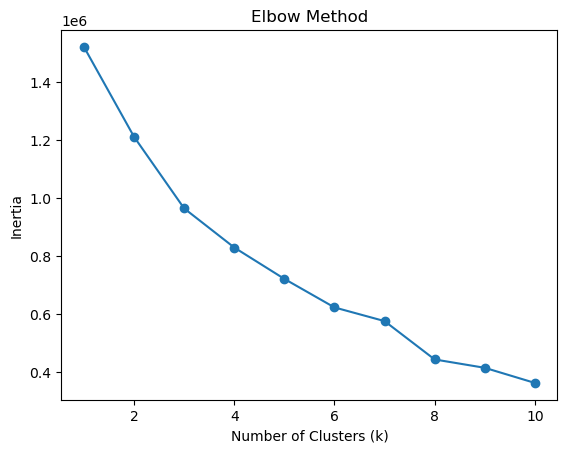

In [17]:
# first group includes variables related to physical health status :
# pull features we want 
features = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack']
X = df[features]
# scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# determine optimal number of clusters 
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [18]:
k = 3  # 3 is optimal number of clusters
kmeans = KMeans(n_clusters=k, init = 'k-means++',random_state=10)
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

In [19]:
df['Cluster_KMeans'] = labels_kmeans

#### Visualization of Clusters
- we see all of blue cluster has no high blood pressure whereas all of yellow cluster has high blood pressure.
- majority of purple cluster has high blood pressure with some observations having no high blood pressure but a high bmi.

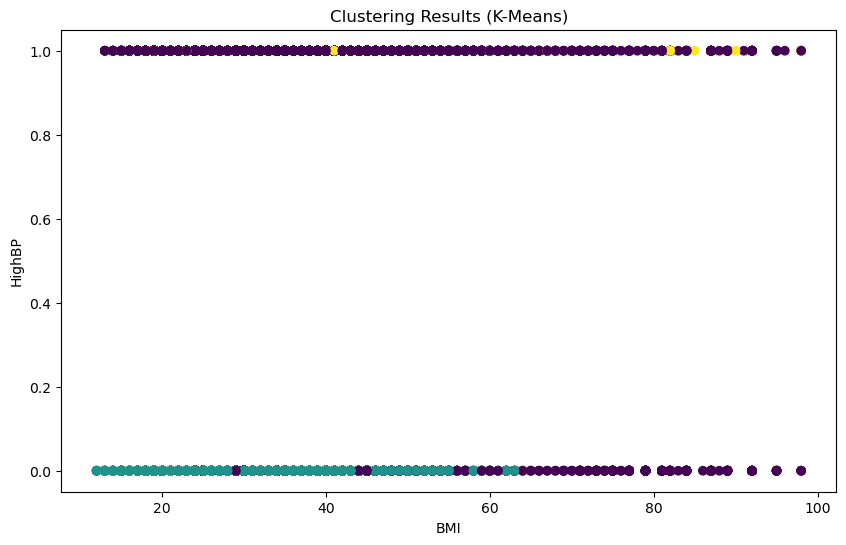

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df['BMI'], df['HighBP'], c=df['Cluster_KMeans'], cmap='viridis')
plt.xlabel('BMI')
plt.ylabel('HighBP')
plt.title('Clustering Results (K-Means)')
plt.show()


#### Diabetes by Cluster
- about 32% of cluster two has diabetes whereas 24% of cluster 0 has diabetes and 5% of cluster 1
- most of cluster 0 and 2 have high blood pressure whereas cluster 1 has no high bp
- when we visualize this, we hope to see the clusters split by diabetic status. instead, all clusters have a percentage of diabetics.  

In [23]:
# what percentage of each cluster has diabetes?
dia_per_cluster = df.groupby('Cluster_KMeans')['diabetes1'].mean()
highbp_per_cluster = df.groupby('Cluster_KMeans')['HighBP'].mean()
print("Percentage of Cluster with Diabetes: ")
print(dia_per_cluster)
print("Percentage of Cluster with High Blood Pressure: ")
print(highbp_per_cluster)

Percentage of Cluster with Diabetes: 
Cluster_KMeans
0    0.235079
1    0.054678
2    0.317528
Name: diabetes1, dtype: float64
Percentage of Cluster with High Blood Pressure: 
Cluster_KMeans
0    0.972685
1    0.000000
2    0.740867
Name: HighBP, dtype: float64


<Figure size 1000x600 with 0 Axes>

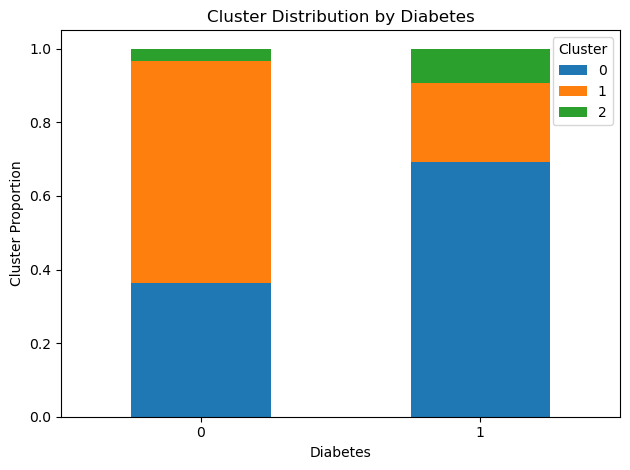

In [24]:
# visualize prevalence of diabetes within each cluster
# should be very split; this isnt great 
health_cluster_group = df.groupby(['diabetes1', 'Cluster_KMeans']).size().unstack(fill_value=0)

health_cluster_group_norm = health_cluster_group.div(health_cluster_group.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
health_cluster_group_norm.plot(kind='bar', stacked=True)
plt.title('Cluster Distribution by Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Cluster Proportion')
plt.legend(title='Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Explore differences within clusters
- note: none of 1 has highBP, very low heart attacks, younger on average, higher income
- 0 and 2 are pretty similar 
- Exclude non-numeric columns

In [25]:
numeric_columns = df.select_dtypes(include=np.number)
# group by cluster 
cluster_stats = numeric_columns.groupby('Cluster_KMeans').mean()
print(cluster_stats)

                diabetes    HighBP  HighChol  CholCheck        BMI    Smoker  \
Cluster_KMeans                                                                 
0               0.496982  0.972685  0.592824   0.983690  30.284653  0.497165   
1               0.120660  0.000000  0.281710   0.945329  26.914096  0.391935   
2               0.660805  0.740867  0.646716   0.984940  29.030023  0.590944   

                Stroke  HeartDiseaseorAttack  PhysActivity    Fruits  ...  \
Cluster_KMeans                                                        ...   
0                  0.0              0.162092      0.701036  0.611835  ...   
1                  0.0              0.022183      0.808651  0.653313  ...   
2                  1.0              0.382530      0.612223  0.602895  ...   

                NoDocbcCost  mentHealth  physHealth  DiffWalk       Sex  \
Cluster_KMeans                                                            
0                  0.087096    3.533197    5.523317  0.247208  

#### Clustering with Demographics Variables
- variables include income, education level, gender, age, healthcare status, and general health level

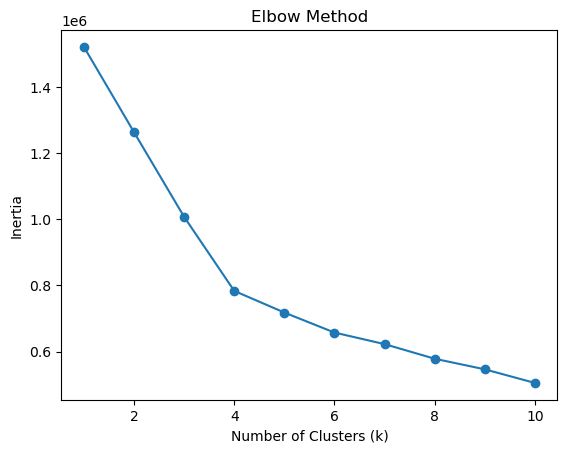

In [26]:
# second group includes variables about demographics 
features = ['Income', 'education', 'Sex', 'Age', 'AnyHealthcare','genHealth']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# determine optimal number of clusters 
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [27]:
k = 3  # Choose the optimal number of clusters based on the elbow plot
kmeans = KMeans(n_clusters=k, init = 'k-means++',random_state=10)
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

In [28]:
df['Cluster_KMeans1'] = labels_kmeans

#### Visualizing income and general health within clusters
- majority of purple cluster has higher income and better health 
- majority of blue cluster has a lower income and worse general health
- yellow cluster is not represented 

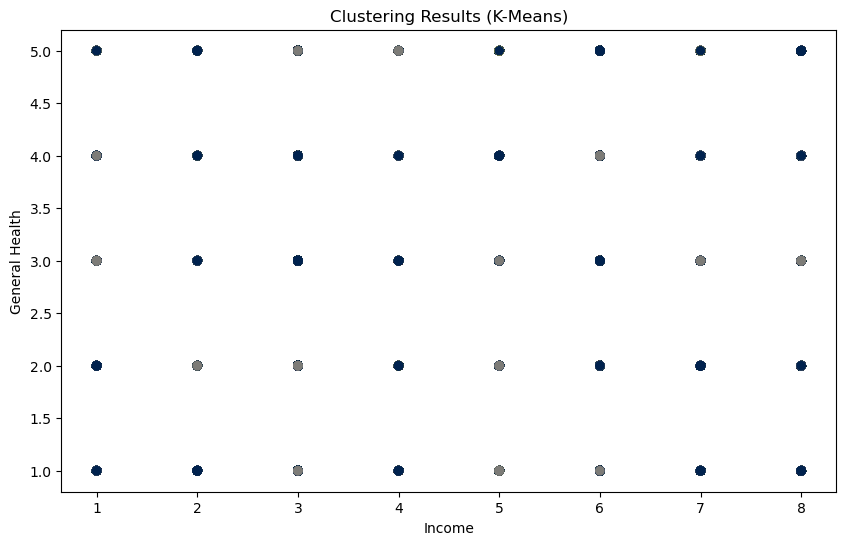

In [29]:
# income and general health within clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['Income'], df['genHealth'], c=df['Cluster_KMeans1'], cmap='cividis')
plt.xlabel('Income')
plt.ylabel('General Health')
plt.title('Clustering Results (K-Means)')
plt.show()

#### Diabetes by Cluster
- each cluster has a very similar proportion of diabetics; 13%, 15%, and 11%, respectively. this clustering isn't very insightful into what differentiates diabetics and non-diabetics. 

In [34]:
# what percentage of each cluster has diabetes?
dia_per_cluster = df.groupby('Cluster_KMeans1')['diabetes1'].mean()
print(dia_per_cluster)

Cluster_KMeans1
0    0.130068
1    0.154128
2    0.114520
Name: diabetes1, dtype: float64


<Figure size 1000x600 with 0 Axes>

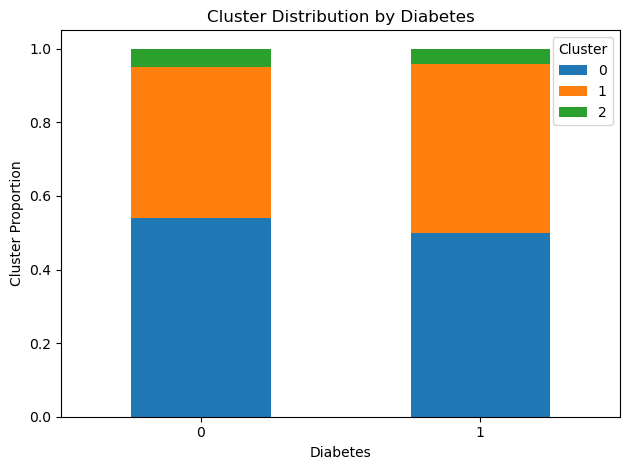

In [37]:
health_cluster_group = df.groupby(['diabetes1', 'Cluster_KMeans1']).size().unstack(fill_value=0)

health_cluster_group_norm = health_cluster_group.div(health_cluster_group.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
health_cluster_group_norm.plot(kind='bar', stacked=True)
plt.title('Cluster Distribution by Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Cluster Proportion')
plt.legend(title='Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Clustering insights
- cluster 1 has more highBP and diabetes, more smokers, higher chol and BMI, older
- 0 and 2 are pretty similar but 0 has more physical activity and better mental health 

In [38]:
# Exclude non-numeric columns
numeric_columns = df.select_dtypes(include=np.number)
# group by cluster 
cluster_stats = numeric_columns.groupby('Cluster_KMeans1').mean()
print(cluster_stats)

                 diabetes    HighBP  HighChol  CholCheck        BMI    Smoker  \
Cluster_KMeans1                                                                 
0                0.278321  0.409835  0.413981   0.970292  28.086410  0.399788   
1                0.326343  0.463424  0.447929   0.964441  28.698660  0.492815   
2                0.249497  0.345172  0.332125   0.864379  28.920432  0.494081   

                   Stroke  HeartDiseaseorAttack  PhysActivity    Fruits  ...  \
Cluster_KMeans1                                                          ...   
0                0.040420              0.072430      0.747278  0.676169  ...   
1                0.041661              0.124916      0.776315  0.588378  ...   
2                0.032939              0.070065      0.689377  0.567287  ...   

                 mentHealth  physHealth  DiffWalk       Sex       Age  \
Cluster_KMeans1                                                         
0                  3.628253    4.558243  0.1920

### Clustering Results 

K-means clustering was implemented to group data points together based on their features, so that the points in each cluster were as similar as possible. The data was clustered twice based on a different selection of variables. The first group of variables centered around physical health and included variables such as high blood pressure, high cholesterol, smoker/not, and BMI. Two of the clusters had very similar characteristics, and diabetes status was not captured very well from this grouping. Notably, cluster 1 differed significantly from the other two in that no one had highBP, there were not many heart attacks / diseases, people were younger on average, and had a higher income.

The second grouping based on personal demographics was slightly better as it accounted for sex, age, income, education, etc. The groups were even more different among themselves, and we found a negative relationship between income and general health. Also, the cluster with a higher percentage of diabetics had on average, lower general health. Based on their stats, cluster 1 was again very different than the other two except this time, on average, there were more diabetics, smokers, and older people within the cluster. Overall, while K-means clustering was helpful, we were not able to uncover many other underlying patterns within the data.

### Modeling Diabetic Status
#### Logistic Regression Multinomial: three outcomes
- classifying data based on diabetic, prediabetic, or not diabetic
- split the data into test and training sets to evaluate model performance
- standardize features to ensure they have the same scale and avoid skewing results
- 85% accurate

In [48]:
X = df[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'mentHealth', 'physHealth', 'DiffWalk', 'Sex', 'Age',
       'Income', 'genHealth', 'education']]
y = df['diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8483522548092085


#### Logistic Regression Bivariate: two outcomes
- classification based on diabetic or not
- same process as detailed above
- 87% accurate 

In [49]:
X = df[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'mentHealth', 'physHealth', 'DiffWalk', 'Sex', 'Age',
       'Income', 'genHealth', 'education']]
y = df['diabetes1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8657954903815831


In [50]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
def classify_based_on_threshold(predicted_probabilities, threshold=0.6):
    return (predicted_probabilities >= threshold).astype(int)

# Make predictions for the entire dataset
predicted_probabilities = model.predict(X)

# Classify each observation based on the 0.5 threshold
classifications = classify_based_on_threshold(predicted_probabilities)

# Add classifications to the DataFrame
df['predicted_diabetes'] = classifications

In [52]:
# calculate misclassification rate 
misclassification_rate = 1 - accuracy_score(y_test, y_pred)
print("Misclassification Rate:", misclassification_rate)

Misclassification Rate: 0.1342045096184169


#### Decision Tree Classifier 
- with no tuning, the tree has an accuracy of 80%
- find the best depth for the tree where the model is most accurate
- best depth is 7 with accuracy of 87% 

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# decision tree with defaults
decision_tree = DecisionTreeClassifier(random_state=42)

# train 
decision_tree.fit(X_train, y_train)

# predict on testing data
y_pred = decision_tree.predict(X_test)

# calc accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7980329549038159


In [54]:
# hyperparameter tuning
# Initialize variables to store best accuracy and corresponding depth
best_accuracy = 0
best_depth = None

# Try different depths for the decision tree
for depth in range(1, 11):  # Try depths from 1 to 10
    # Create a decision tree classifier with the current depth
    dt_classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Train the classifier on the training data
    dt_classifier.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = dt_classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Check if current model is the best one so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print("Best depth:", best_depth)
print("Best accuracy:", best_accuracy)

Best depth: 7
Best accuracy: 0.8662093976663513


- visualizing the tree makes it difficult to interpret since it is so deep 

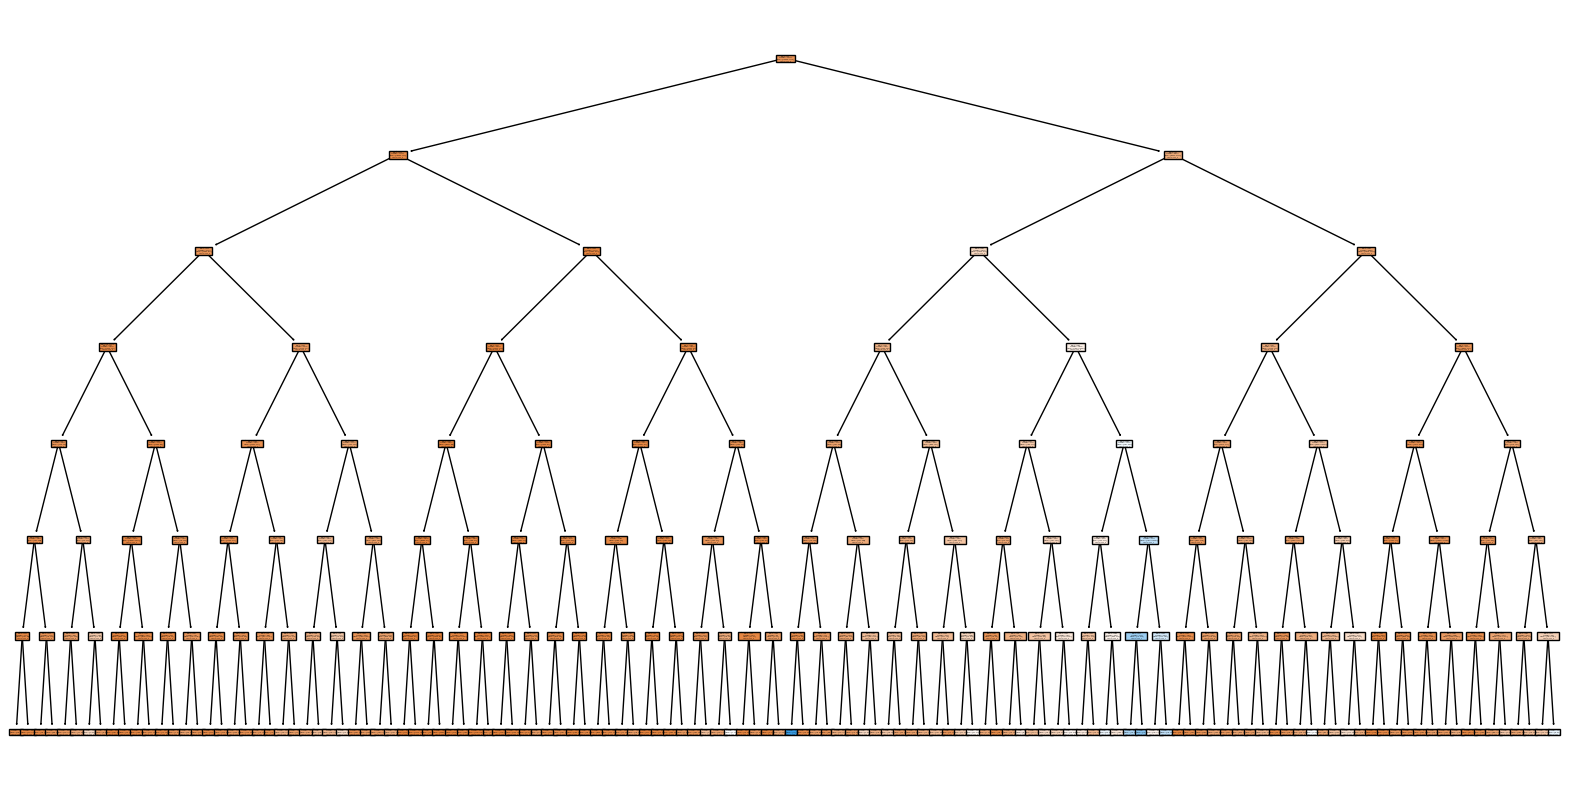

In [59]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Create a decision tree classifier with depth 7
dt_classifier = DecisionTreeClassifier(max_depth=7, random_state=42)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=list(X_train.columns), class_names=['class_0', 'class_1'])
plt.show()
# difficult to interpret 

#### Cross Validation
- cross validate the models with K-Fold CV to provide a better estimate of model performance
- we can compare how the models perform on the same subsets of data to determine which is more accurate
- the models are very comparable with the decision tree having a slight advantage in regards to average accuracy and standard deviation

In [60]:
# cross validation 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def k_fold_cv(model, X, y, k):
    kf = KFold(n_splits=k, random_state=10, shuffle=True)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return accuracies

In [61]:
X = df[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'mentHealth', 'physHealth', 'DiffWalk', 'Sex', 'Age',
       'Income', 'genHealth', 'education']]

dt_accuracies_unscaled = k_fold_cv(dt_classifier, X.values, y, k=10)
lr_accuracies_unscaled = k_fold_cv(model, X.values, y, k=10)

print(f"Decision Tree - Mean Accuracy: {np.mean(dt_accuracies_unscaled):.4f}, Std: {np.std(dt_accuracies_unscaled):.4f}")
print(f"Logistic Regression - Mean Accuracy: {np.mean(lr_accuracies_unscaled):.4f}, Std: {np.std(lr_accuracies_unscaled):.4f}")

Decision Tree - Mean Accuracy: 0.8646, Std: 0.0016
Logistic Regression - Mean Accuracy: 0.8635, Std: 0.0017


### Model Comparison

In terms of predicting diabetic status, two logistic regression models and one decision tree were built. The multinomial regression was able to group diabetics, prediabetics, and those with no diabetes with 85% accuracy. In comparison, the bivariate model whose outcome is either diabetic or not diabetic, was able to classify the data with 87% accuracy. After tuning the hyperparameters of the decision tree to find the best model, it produced an accuracy of about 87%. However, this model has a depth of 7, which has a low interpretability. After cross-validating, the bivariate logistic regression model and decision tree were very comparable, with the decision tree proving to have higher accuracy and lower standard deviation.

### Conclusion

The goal of this analysis was to find the best model to classify data based on diabetic status. From the correlation analysis, we can conclude that as age increases, so does the risk of having high blood pressure. While the dataset was not optimal for clustering as two of the clusters were always very similar, we found there is a negative relationship between income and general health that can be further explored to determine how wealth impacts disease prevalence. We can use this relationship to better help those who may not be able to afford health care and prevent diabetes as a result. After cross-validating the classification models, the tuned decision tree was 87% accurate in predicting diabetic status. This model can be used on other datasets to help predict who may be at risk of having diabetes, aiding in early identification.